# Modelo *RMFT* ($\sigma^4$-$\omega$-$\boldsymbol{\rho}$)

In [1]:
# Importamos las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 3
from scipy.interpolate import CubicSpline

import scripts.IsospinEoS as isoEoS
import scripts.ResolverTOV as tov

## Ecuacion de Estado del Modelo

### Ecuaciones de la teoría

Luego de incorporar la autointeracción del campo escalar $\sigma$, agregamos al lagrangiano del modelo el triplete vectorial de isospin $\mathbf{\rho}$, cuya forma es, en unidades naturales $c=\hbar=1$,
$$\mathcal{L}_\rho = -\frac{1}{4}\boldsymbol{\rho}_{\mu\nu}\boldsymbol{\rho}^{\mu\nu} + \frac{1}{2}m_\rho^2\boldsymbol{\rho}_\mu\boldsymbol{\rho}^\mu - \frac{1}{2} g_\rho \bar\psi\gamma^\mu \boldsymbol{\tau} \cdot \boldsymbol{\rho}_\mu \psi,$$

donde hemos tomado únicamente el acople entre la corriente de isospin de los nucleones y el campo isovectorial $\boldsymbol{\rho}$, y hemos omitido el acople de la corriente de isospin del mismo campo, pues estos términos se hacen cero al aplicar la aproximación de campo medio, donde la única componente diferente de cero es la componente temporal del campo neutral $\rho_3^0$.

Ahora, podemos escribir las ecuaciones de autoconsistencia, energía y presión empleando las variables y parámetros adimensionales $\tilde x_{\sigma} = 1-g_{\sigma}\sigma/m, \quad \tilde n = n/m^3, \quad x_i = p_i/m \; (i = n,\,p),\quad \tilde A_{i} = (g_i/m_i)^2m^2, \quad t = (n_p - n_n)/n\,$; y la constante $\lambda = m^4$ con unidades de densidad de energía $\text{MeV/fm}^3$ o equivalentemente $\text{fm}^{-4}$

$$ (1-\tilde x_{\sigma}) - \tilde A_{\sigma}\left[\frac{1}{\pi^2} \left(\int_0^{x_{nF}(n)} \frac{\tilde x_{\sigma} x^2 dx}{\sqrt{x^2 + \tilde x_{\sigma}^2}} + \int_0^{x_{pF}(n)} \frac{\tilde x_{\sigma} x^2 dx}{\sqrt{x^2 + \tilde x_{\sigma}^2}} \right) - b (1-\tilde x_{\sigma})^2 - c (1-\tilde x_{\sigma})^3\right] = 0$$

\begin{aligned}
\tilde\rho = \frac{\lambda}{2\rho_0} \Bigg[ & (1-\tilde x_{\sigma})^2\left(\tilde A_{\sigma}^{-1} + \frac{2}{3} b(1-\tilde x_{\sigma}) + \frac{1}{2} c(1-\tilde x_{\sigma})^2\right) \\
& + \left(\tilde A_{\omega} + \frac{1}{4} \tilde A_{\rho} t^2\right) \tilde n^2 + \frac{2}{\pi^2} \left(\int_0^{x_{nF}(n)} x^2 \sqrt{x^2 + \tilde x_{\sigma}^2} dx + \int_0^{x_{pF}(n)} x^2 \sqrt{x^2 + \tilde x_{\sigma}^2} dx\right) \Bigg]\\

\tilde P = \frac{\lambda}{2\rho_0} \Bigg[ & -(1-\tilde x_{\sigma})^2\left(\tilde A_{\sigma}^{-1} + \frac{2}{3} b(1-\tilde x_{\sigma}) + \frac{1}{2} c(1-\tilde x_{\sigma})^2\right) \\
& + \left(\tilde A_{\omega} + \frac{1}{4} \tilde A_{\rho} t^2\right) \tilde n^2 + \frac{2}{3\pi^2} \left(\int_0^{x_{nF}(n)} \frac{x^4 dx}{\sqrt{x^2 + \tilde x_{\sigma}^2}} + \int_0^{x_{pF}(n)} \frac{x^4 dx}{\sqrt{x^2 + \tilde x_{\sigma}^2}}\right) \Bigg]
\end{aligned}

### Ecuación de estado numérica

In [2]:
# Definimos las constantes necesarias en MKS
hbar_MKS = 1.0545718e-34 # J s
c_MKS = 299792458 # m/s
G_MKS = 6.67430e-11 # m^3/kg/s^2
pi = np.pi
proton_mass = 1.6726219e-27 # kg
neutron_mass = 1.6749275e-27 # kg
m_nuc_MKS = (proton_mass + neutron_mass)/2.0 # kg
e_MKS = 1.602186021766e-19 # C

# Algunas converciones útiles (multiplicar al primero para obtener el segundo)
Kg_to_fm11 = c_MKS/hbar_MKS*1e-15 # kg to fm^-1
MeV_to_fm11 = e_MKS/(hbar_MKS*c_MKS*1e9) # MeV to fm^-1
MeVfm_to_Jm  = 1e51*e_MKS # MeV/fm to J/m

# Definimos las constantes necesarias en unidades naturales
m_nuc =  m_nuc_MKS * Kg_to_fm11 # fm^-1
lambda_ = m_nuc**4 # Constante de escala empleada
rho_0_lambda = lambda_/2 # Escala de energía y presión empleada


# Damos valores a las constantes (Glendenning K=200 m*/m=0.7) (constantes tilde cuadradas)
A_sigma = 12.684*m_nuc**2 # Walecka: 266.9, 357.4
A_omega =  7.148*m_nuc**2 # Walecka: 195.7, 273.8
A_rho   =  4.410*m_nuc**2 # Nuevo parámetro para el campo rho
b       =  5.610e-3
c       = -6.986e-3
t       =  0.0            # Parámetro de asimetría de isospin (prot-neut, t=0 simétrica, t=+-1 asimétrica)

params = [A_sigma, A_omega, A_rho, b, c, t]

# Calculamos si no hay archivo de la EoS, si no, lo leemos
operacion = 'leer' # 'calc' o 'leer'

if operacion == 'calc':
    # Definimos el rango de densidades para la interpolación de la EoS
    densidad_masa_max = 1e18*1e3*(1e-45/m_nuc_MKS) # g/cm^3 a kg/m^3 a 1/fm^3
    densidad_masa_min = 1e10*1e3*(1e-45/m_nuc_MKS) # g/cm^3 a kg/m^3 a 1/fm^3
    n_barions = np.logspace(np.log10(densidad_masa_min), np.log10(densidad_masa_max), 200)
    # Calculamos la EoS
    rho_P, presiones, energias, n_sirve, presion_cambio = isoEoS.EoS(n_barions, params)
    df = pd.DataFrame({'n': n_sirve[presion_cambio:], 'P': presiones[presion_cambio:], 'E': energias[presion_cambio:]})
    df.to_csv('EoS_tables/SigmaOmegaRho_rho0_lambda_A_propios.csv', index=False, float_format='%.15e')
elif operacion == 'leer':
    # Leemos los resultados de la EoS
    df = pd.read_csv('EoS_tables/SigmaOmegaRho_rho0_lambda_A_propios.csv')
    n_sirve = df['n'].values
    presiones = df['P'].values
    energias = df['E'].values
    rho_P = CubicSpline(presiones, energias)
    presion_cambio = False

## Solución de las Ecuaciones Hidrostáticas

In [3]:
# Si la variable presion_cambio no es false, redefinimos los arrays
if presion_cambio:
    # Definimos la densidad de bariones y la presión para la integración del sistema
    n_sirve = n_sirve[presion_cambio:]
    presiones = presiones[presion_cambio:]
    energias = energias[presion_cambio:]
    rho_P = CubicSpline(presiones, energias)

# Definimos la ecuacion de estado para la integración del sistema
print("Primer densidad de barinoes util", "{:2.2e}".format(n_sirve[0]), "1/fm^3 por ende densidad de masa", format(n_sirve[0]*1e45*m_nuc_MKS*1e-3,"2.2e"), "g/cm^3 y presión", format(presiones[0], "2.2e"), "adimensional")
densidad_limite = energias[0] # Densidad de energia límite adimensional para rho_0 = lambda/2
P_rho = CubicSpline(energias, presiones) # Presión en función de la densidad de energía para rho_0 = lambda/2
P_central = P_rho(1) # Presión central en unidades adimensionales para rho_0 = lambda/2

# Definimos los parametros de integración
rf = 20 # Radio final adimensional
dr = 1e-3 # Paso de integración adimensional

# Resolvemos el sistema TOV
rho_nat_to_MKS = 1.0 / MeV_to_fm11 * MeVfm_to_Jm
sol_final = tov.integrador(rf, dr, rho_0_lambda*rho_nat_to_MKS, rho_P, P_central, densidad_limite=densidad_limite)
# Orden: r, m, rho, P, phi
print("Radio final = ", sol_final[0]/1e3, "km, Masa final = ", sol_final[1]/1.989e30, "M_sun")
# tov.graficar_solucion(rf, dr, rho_0_lambda, rho_P, P_central, densidad_limite=densidad_limite)

Primer densidad de barinoes util 1.58e-01 1/fm^3 por ende densidad de masa 2.64e+14 g/cm^3 y presión 2.28e-06 adimensional
Radio final =  8.261743096477232 km, Masa final =  1.6786072766631894 M_sun


c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:163: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T


Masa máxima: 2.327 M_sun para rho0_m = 1.686e+15 g/cm^3


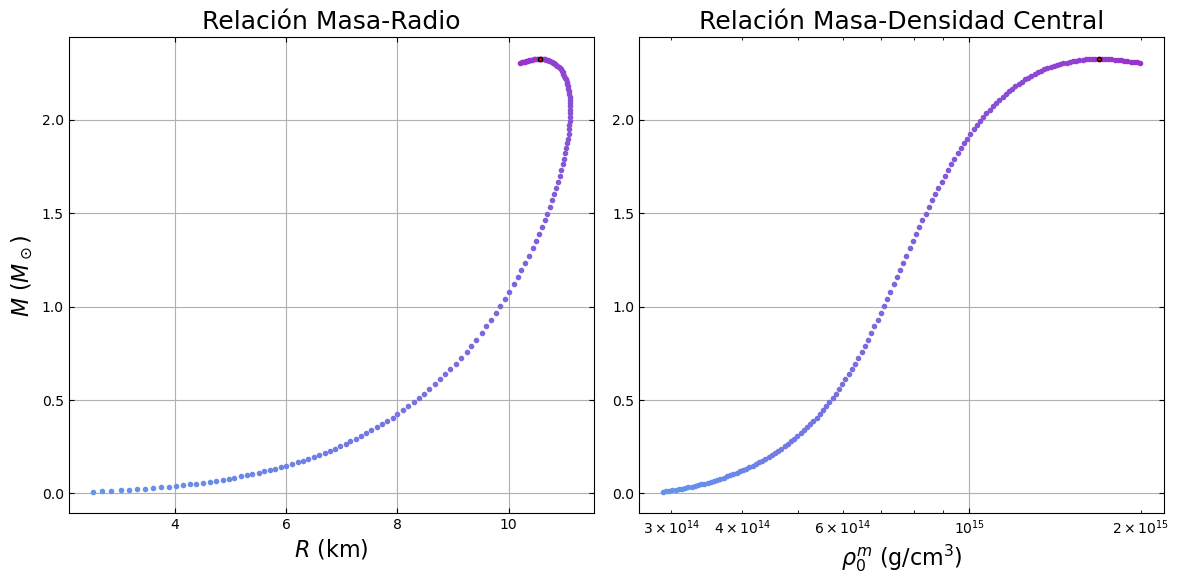

In [4]:
# Definimos el espacio de densidades centrales de masa para la integración
rhos_masa = np.logspace(np.log10(n_sirve[1]*1e45*m_nuc_MKS*1e-3), 15.3, 150) # Densidades de masa en g/cm^3 (desde donde es util la EoS)
# rhos_masa = np.logspace(14, 18, 100) # Densidades de masa en kg/m^3

# Calculamos la densidad de energía asociada a cada densidad de masa
rhos = []
for rho_m in rhos_masa:
    densidad_energia, _ = isoEoS.energia_presion(rho_m*1e3/m_nuc_MKS*1e-45, params)
    rhos.append(densidad_energia)
    
# Definimos arrays para la masa y el radio
masas = np.zeros(len(rhos))
radios = np.zeros(len(rhos))

# Resolvemos el sistema TOV para cada densidad central de masa
arg_max = 0
for i in range(len(rhos)):
    rho0 = rhos[i] # Densidad de energía central adimensionalizada con rho_0_lambda
    R = 1.0/rho0 # Factor de conversión para la interpolación adimensionalizada con rho0
    rho_P_prima = lambda P: R*rho_P(P/R) # Interpolación adimensionalizada con rho0 (en función de P adimensional con rho0)
    P_central_prima = R*P_rho(1/R) # Presión central adimensionalizada con rho0
    densidad_limite_prima = R*densidad_limite # Densidad de energía límite adimensionalizada con rho0
    sol_final = tov.integrador(rf, dr, rho0*rho_0_lambda*rho_nat_to_MKS, rho_P_prima, P_central_prima, densidad_limite=densidad_limite_prima)
    radios[i] = sol_final[0] # Radio final en metros
    masas[i] = sol_final[1] # Masa final en kg
    if masas[i] > masas[arg_max]:
        arg_max = i
    # print("Se pudo para densidad de masa =", format(rho_m,"2.2e"), "g/cm^3")
    
# Guardamos los resultados en un archivo MasaRadio_SigmaOmegaRho_rho0_lambda_A_propios.csv
m_sun = 1.989e30 # kg
df = pd.DataFrame({'Masa': masas/m_sun, 'Radio': radios*1e-3, 'rho_m': rhos_masa})
df.to_csv('results/MasaRadio_SigmaOmegaRho_rho0_lambda_A_propios.csv', index=False, float_format='%.15e')
    
# Graficamos la relación masa-radio
tov.grafica_masa_radio(radios, masas, rhos_masa)

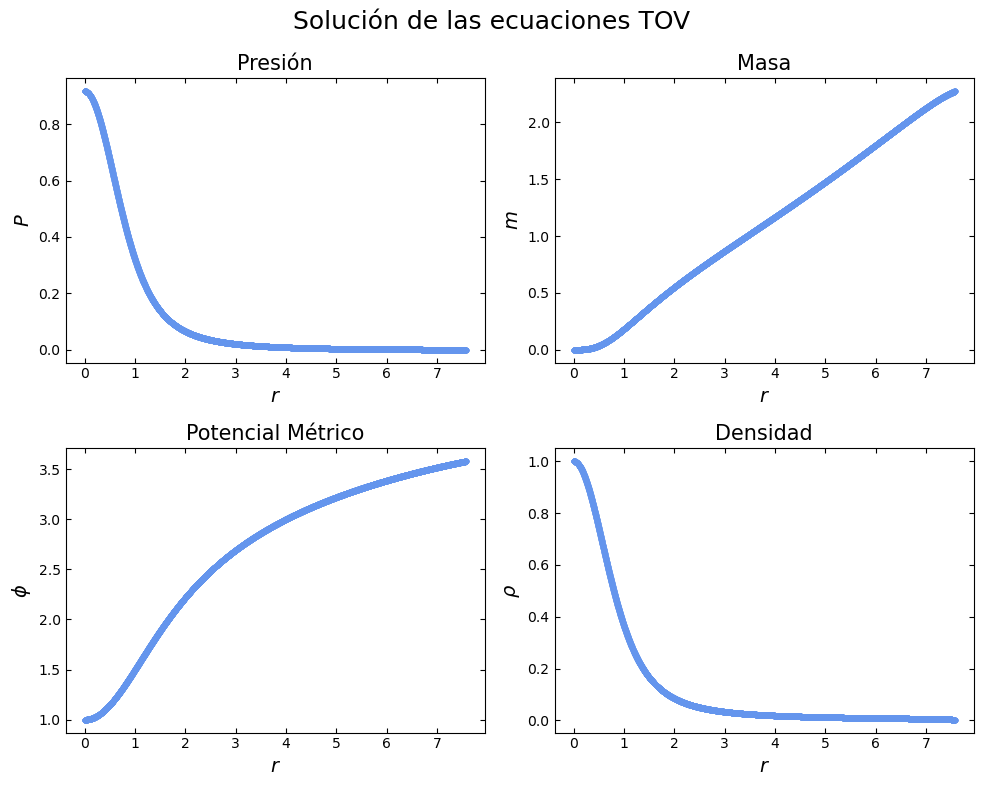

In [22]:
tov.graficar_solucion(rf, dr, rho_0_lambda*rho_nat_to_MKS, rho_P, P_central, densidad_limite=densidad_limite)

## Resultados de la EoS

### Ecuación de autoconsistencia

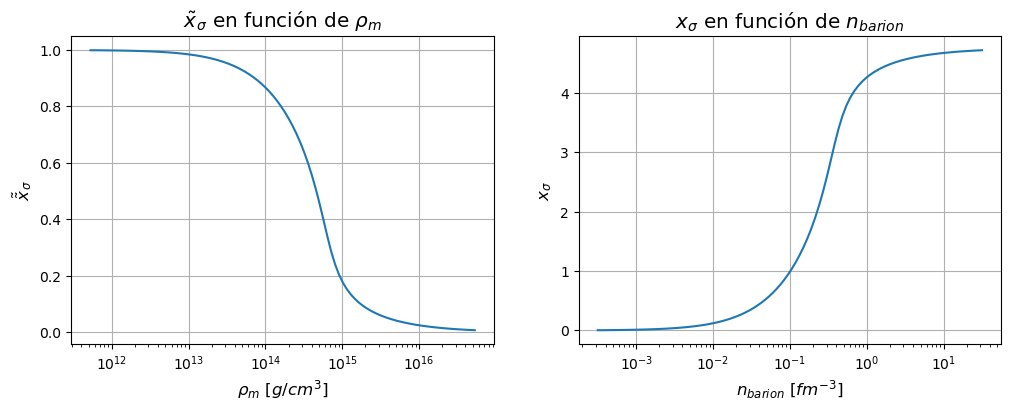

In [4]:
# Testeamos la solucion_x_sigma
n_prove = np.logspace(-3.5, 1.5, 100) 
isoEoS.plot_autoconsistencia(n_prove, params)

### Interpolación y ecuación de estado

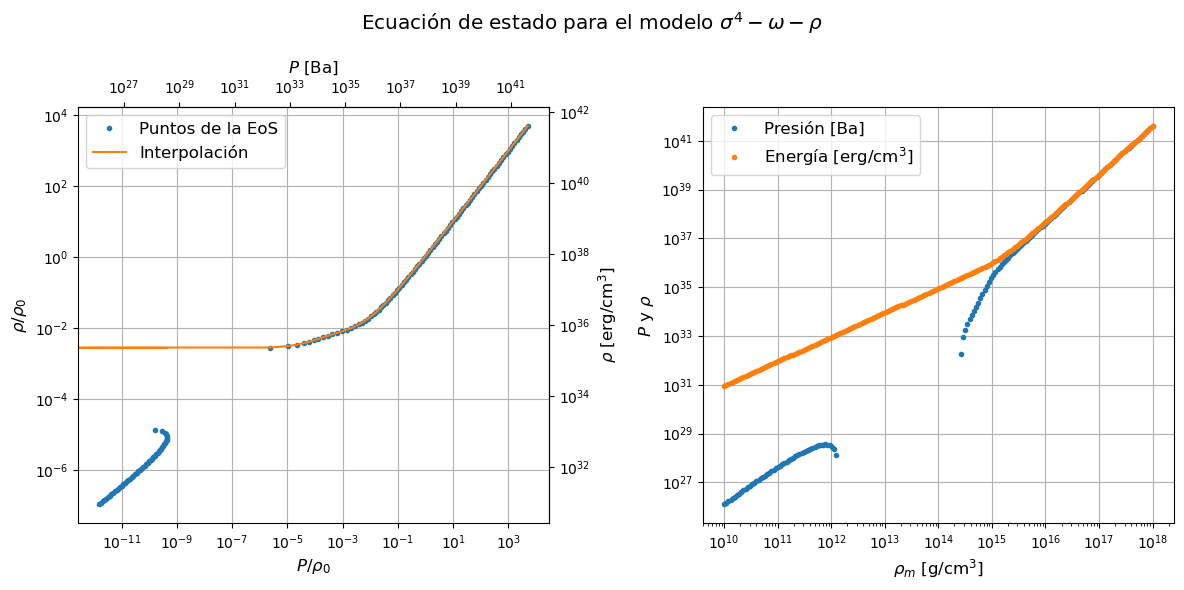

In [3]:
isoEoS.plot_EoS(rho_P, presiones, energias, n_sirve, titulo=r'Ecuación de estado para el modelo $\sigma^4-\omega-\rho$')

### Observables $\frac{B}{A}$, $n_{sat}$, $K_{sat}$ y $a_{sym}$

La masa efectiva en saturación es: 0.700 m_nuc
Densidad de saturación n_saturacion = 0.153 1/fm^3 ( 2.566e+14 g/cm^3 ) y energia de enlace por nucleon en saturación = -16.302 MeV y densidad de energia en saturación = 141.452 MeV/fm^3
Presion en la densidad de saturación: 1.257204054769402e+30 Pa


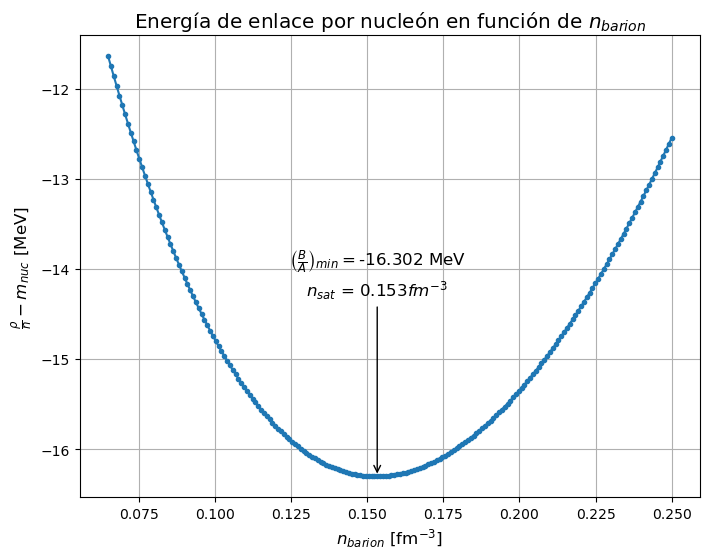

In [5]:
# Graficamos la energia de enlace por nucleon vs la densidad de bariones
# n_prove = np.logspace(-3, -0.5, 200) # Densidades de bariones en fm^-3
n_prove = np.linspace(6.5e-2, 0.25, 200) # Densidades de bariones en fm^-3
saturacion = isoEoS.plot_saturacion(n_prove, params)

In [6]:
# Calculamos el modulo de compresion y el coeficiente de energía de simetría
K = isoEoS.modulo_compresion(saturacion[0], params)
print(f'Modulo de compresion: {K:.4f} MeV')

a_sym = isoEoS.coeficiente_simetria(saturacion[0], params)
print(f'Coeficiente de simetria: {a_sym:.4f} MeV')

Modulo de compresion: 201.2262 MeV
Coeficiente de simetria: 32.5437 MeV


Propiedades para -0.0:
  Saturación: 0.1533 fm^-3
  Energía de enlace: -16.3020 MeV
  Módulo de compresión: 201.0481 MeV
  Coeficiente de simetría: 32.5343 MeV
  Pendiente del coeficiente de simetría: 79.6040 MeV
La masa efectiva en saturación es: 0.700 m_nuc
Densidad de saturación n_saturacion = 0.153 1/fm^3 ( 2.565e+14 g/cm^3 ) y energia de enlace por nucleon en saturación = -16.302 MeV y densidad de energia en saturación = 141.410 MeV/fm^3
Presion en la densidad de saturación: 1.0928305940687052e+30 Pa


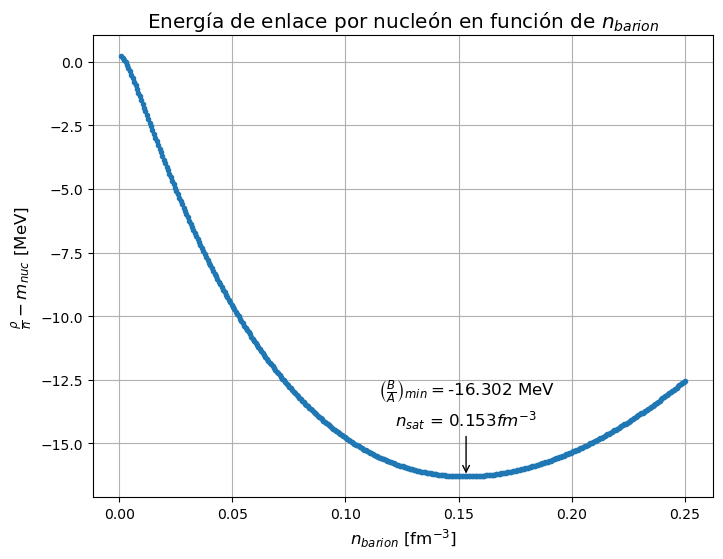

[np.float64(0.15327067669172934), np.float64(-16.30201321153912)]

In [7]:
# Calculamos las propiedades para un cierto t
n_prove = np.linspace(1e-3, .25, 400) # Densidades de bariones en fm^-3
# n_prove = np.logspace(-3, -0.5, 200) # Densidades de bariones en fm^-3
t_test = -0.0
properties = isoEoS.calculate_properties(n_prove, [A_sigma, A_omega, A_rho, b, c, t_test]) # t=0.0 para simetría
print(f'Propiedades para {t_test:.1f}:')
print(f'  Saturación: {properties[0]:.4f} fm^-3')
print(f'  Energía de enlace: {properties[1]:.4f} MeV')
print(f'  Módulo de compresión: {properties[2]:.4f} MeV')
print(f'  Coeficiente de simetría: {properties[3]:.4f} MeV')
print(f'  Pendiente del coeficiente de simetría: {properties[4]:.4f} MeV')
isoEoS.plot_saturacion(n_prove, [A_sigma, A_omega, A_rho, b, c, t_test])

### Dependencia de los observables sobre los parámetros

In [5]:
# Rangos de los parámetros
variaciones = {
    'A_sigma': np.linspace(130, 350, 10),
    'A_omega': np.linspace(100, 250, 10),
    'A_rho': np.linspace(50, 150, 10),
    'b': np.linspace(4.5e-3, 1e-2, 10),
    'c': np.linspace(-0.8e-2, 1e-2, 10)
}

# Rango para buscar saturación
n_prove = np.linspace(1e-3, 0.25, 200) # Densidades de bariones en fm^-3

# Creamos un índice para saber qué posición ocupa cada parámetro en `params`
index_map = {'A_sigma': 0, 'A_omega': 1, 'A_rho': 2, 'b': 3, 'c': 4}

# Diccionario para almacenar resultados
resultados = {}

for nombre, valores in variaciones.items():
    # Inicializamos la entrada para este parámetro
    resultados[nombre] = {
        'values': list(valores),
        'n_sat': [],
        'B/A': [],
        'K': [],
        'a_sym': [],
        'L': []
    }
    for v in valores:
        # Copiamos los parámetros base y sustituimos el que varía
        p = params.copy()
        p[index_map[nombre]] = v
        
        # Calculamos las propiedades
        sat, ebind, Kc, asym, L = isoEoS.calculate_properties(n_prove, p)
        
        # Almacenamos en listas
        resultados[nombre]['n_sat'].append(sat)
        resultados[nombre]['B/A'].append(ebind)
        resultados[nombre]['K'].append(Kc)
        resultados[nombre]['a_sym'].append(asym)
        resultados[nombre]['L'].append(L)

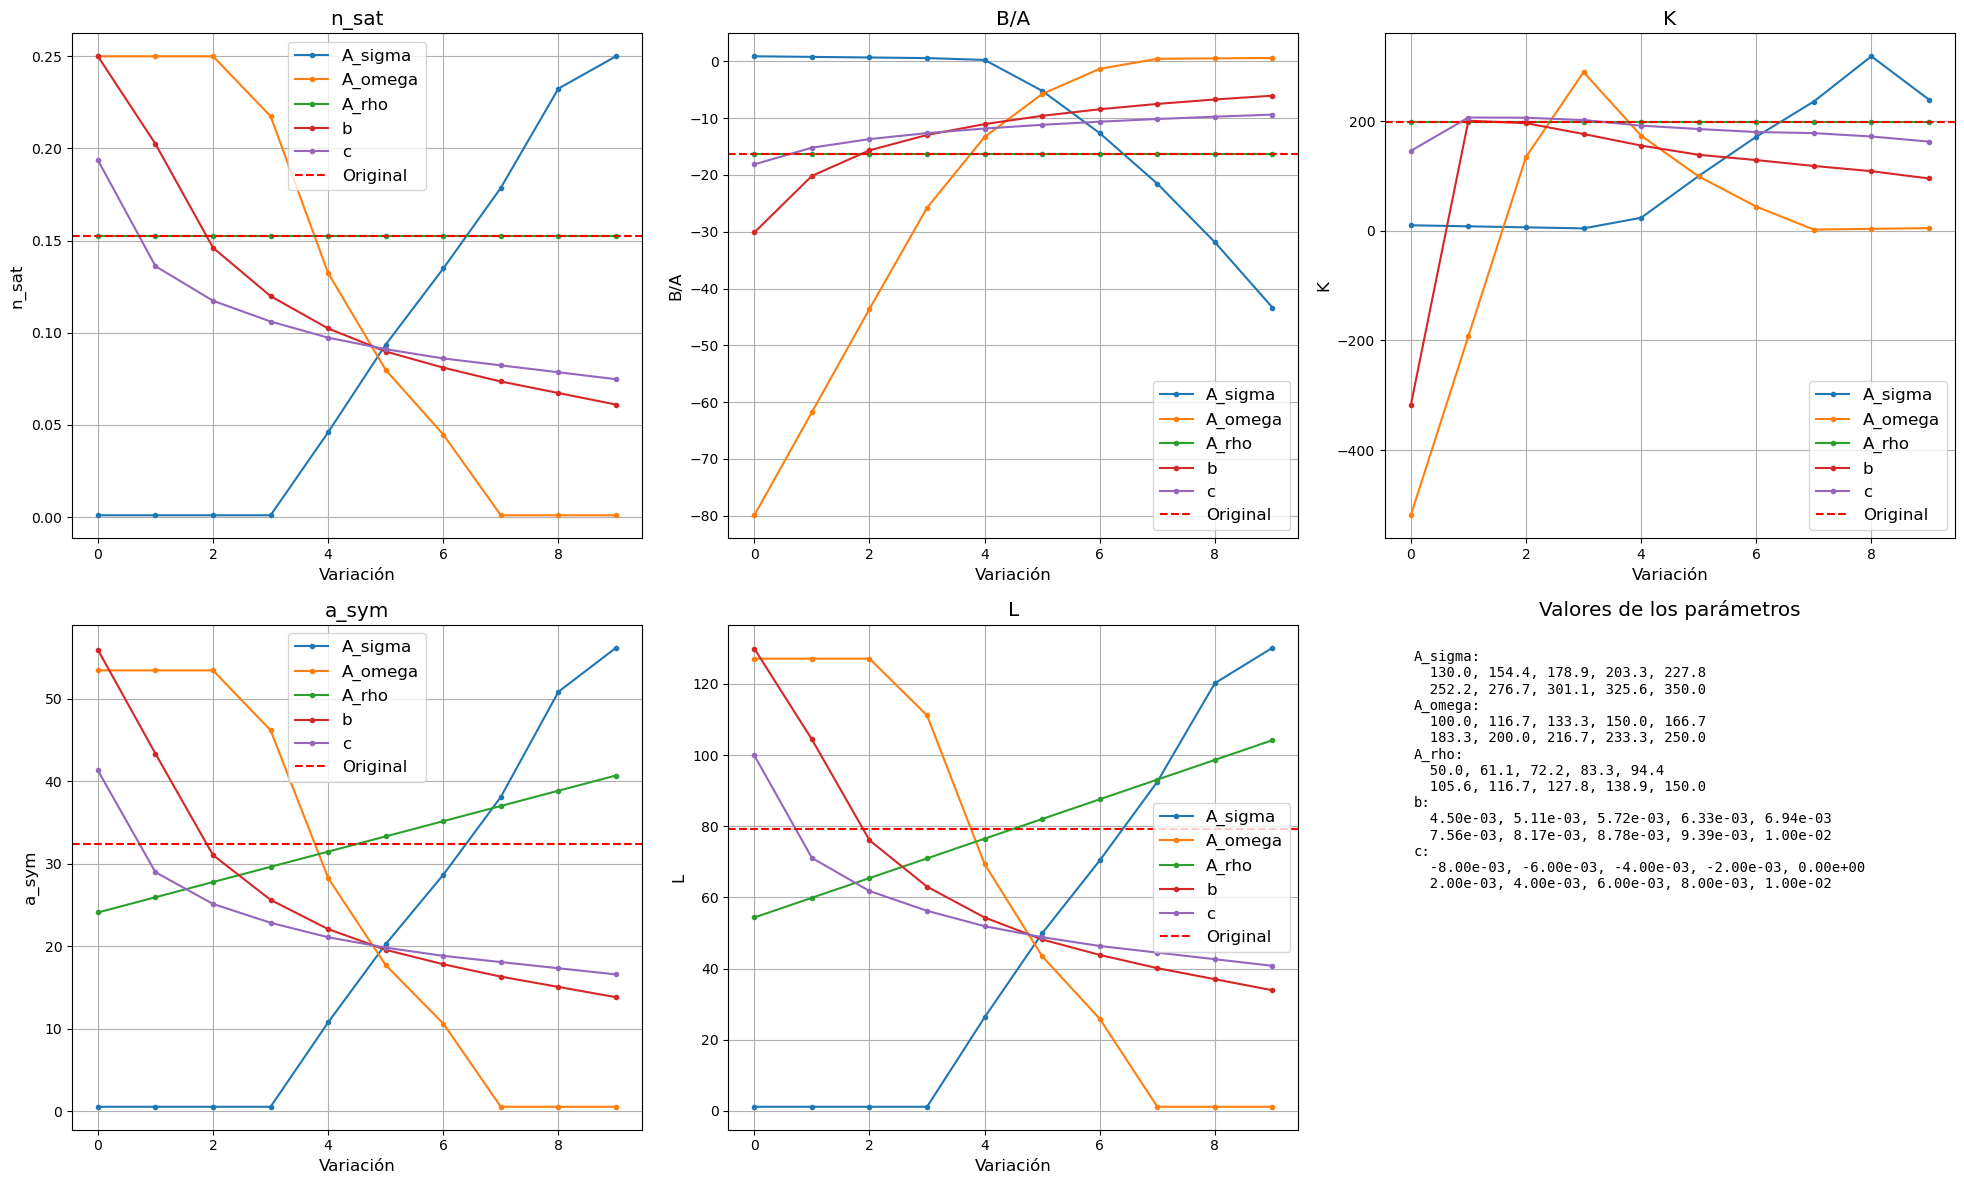

In [6]:
# Invertimos la lógica: una fila por cada propiedad y un sexto panel con los valores de los parámetros
propiedades = ['n_sat', 'B/A', 'K', 'a_sym', 'L']

# Calculamos también los valores originales de las propiedades con los parámetros base
orig_vals = isoEoS.calculate_properties(n_prove, params)

fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# Primeros cinco subplots: variación de cada propiedad al cambiar cada parámetro
for i, prop in enumerate(propiedades):
    ax = axs.flat[i]
    for nombre, datos in resultados.items():
        ax.plot(range(len(datos['values'])), datos[prop], marker='o', label=nombre)
    # Añadimos línea horizontal con el valor original
    ax.axhline(y=orig_vals[i], color='red', linestyle='--', label='Original')
    ax.set_title(prop)
    ax.set_xlabel('Variación')
    ax.set_ylabel(prop)
    ax.legend()
    ax.grid(True)

# Sexto panel: mostrar valores en texto de manera más compacta
ax = axs.flat[5]
ax.axis('off')

# Formatear el texto de manera más compacto y legible
text_lines = []
for nombre, datos in resultados.items():
    if nombre.startswith('A_'):
        valores_str = [f"{v:.1f}" for v in datos['values']]
    else:
        valores_str = [f"{v:.2e}" for v in datos['values']]
    mid = len(valores_str) // 2
    linea1 = ", ".join(valores_str[:mid])
    linea2 = ", ".join(valores_str[mid:])
    text_lines.append(f"{nombre}:")
    text_lines.append(f"  {linea1}")
    text_lines.append(f"  {linea2}")

text = "\n".join(text_lines)
ax.text(0.05, 0.95, text, transform=ax.transAxes,
        ha='left', va='top', fontsize=10, family='monospace')
ax.set_title('Valores de los parámetros')

plt.tight_layout()
plt.show()


c:\ProgramData\Anaconda3\envs\Tesis\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\ProgramData\Anaconda3\envs\Tesis\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


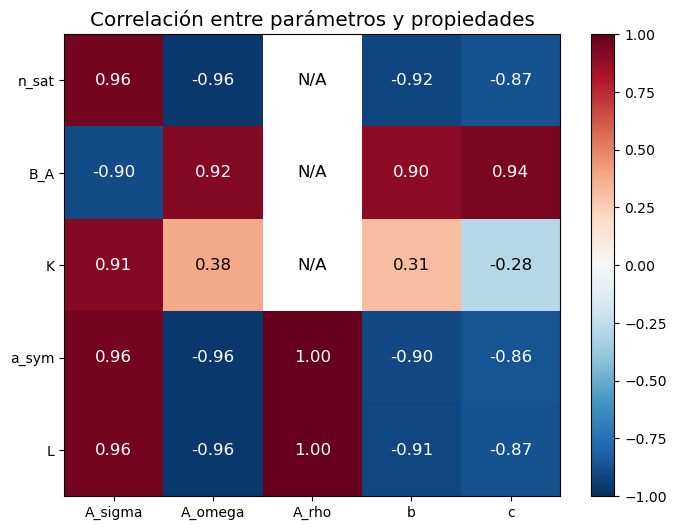

In [27]:
import seaborn as sns

# Crear matriz de correlación entre parámetros y propiedades
# Crear DataFrame a partir del diccionario de resultados
rows = []
for param_name, param_data in resultados.items():
    for i, valor in enumerate(param_data['values']):
        row = {
            'parametro': param_name,
            'valor_param': valor,
            'n_sat': param_data['n_sat'][i],
            'B_A': param_data['B/A'][i], 
            'K': param_data['K'][i],
            'a_sym': param_data['a_sym'][i],
            'L': param_data['L'][i]
        }
        rows.append(row)

df_corr = pd.DataFrame(rows)

# Calcular correlaciones entre valor del parámetro y cada propiedad para cada parámetro
fig, ax = plt.subplots(figsize=(8, 6))

param_names = ['A_sigma', 'A_omega', 'A_rho', 'b', 'c']
propiedades_labels = ['n_sat', 'B_A', 'K', 'a_sym', 'L']

# Matriz de correlación completa
corr_matrix = np.zeros((len(param_names), len(propiedades_labels)))

for i, param in enumerate(param_names):
    df_param = df_corr[df_corr['parametro'] == param]
    for j, prop in enumerate(propiedades_labels):
        corr = np.corrcoef(df_param['valor_param'], df_param[prop])[0,1]
        corr_matrix[i,j] = corr

# Gráfico de mapa de calor de correlaciones
im = ax.imshow(corr_matrix.T, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
ax.set_yticks(range(len(propiedades_labels)))
ax.set_xticks(range(len(param_names)))
ax.set_yticklabels(propiedades_labels)
ax.set_xticklabels(param_names)
ax.set_title('Correlación entre parámetros y propiedades')

# Añadir valores de correlación en el mapa
for i in range(len(param_names)):
    for j in range(len(propiedades_labels)):
        text = ax.text(i, j, f'{corr_matrix[i,j]:.2f}' if not np.isnan(corr_matrix[i,j]) else 'N/A',
                      ha="center", va="center", color="black" if abs(corr_matrix[i,j]) < 0.7 or np.isnan(corr_matrix[i,j]) else "white")

plt.colorbar(im, ax=ax)
plt.show()

### Espacio de Parámetros

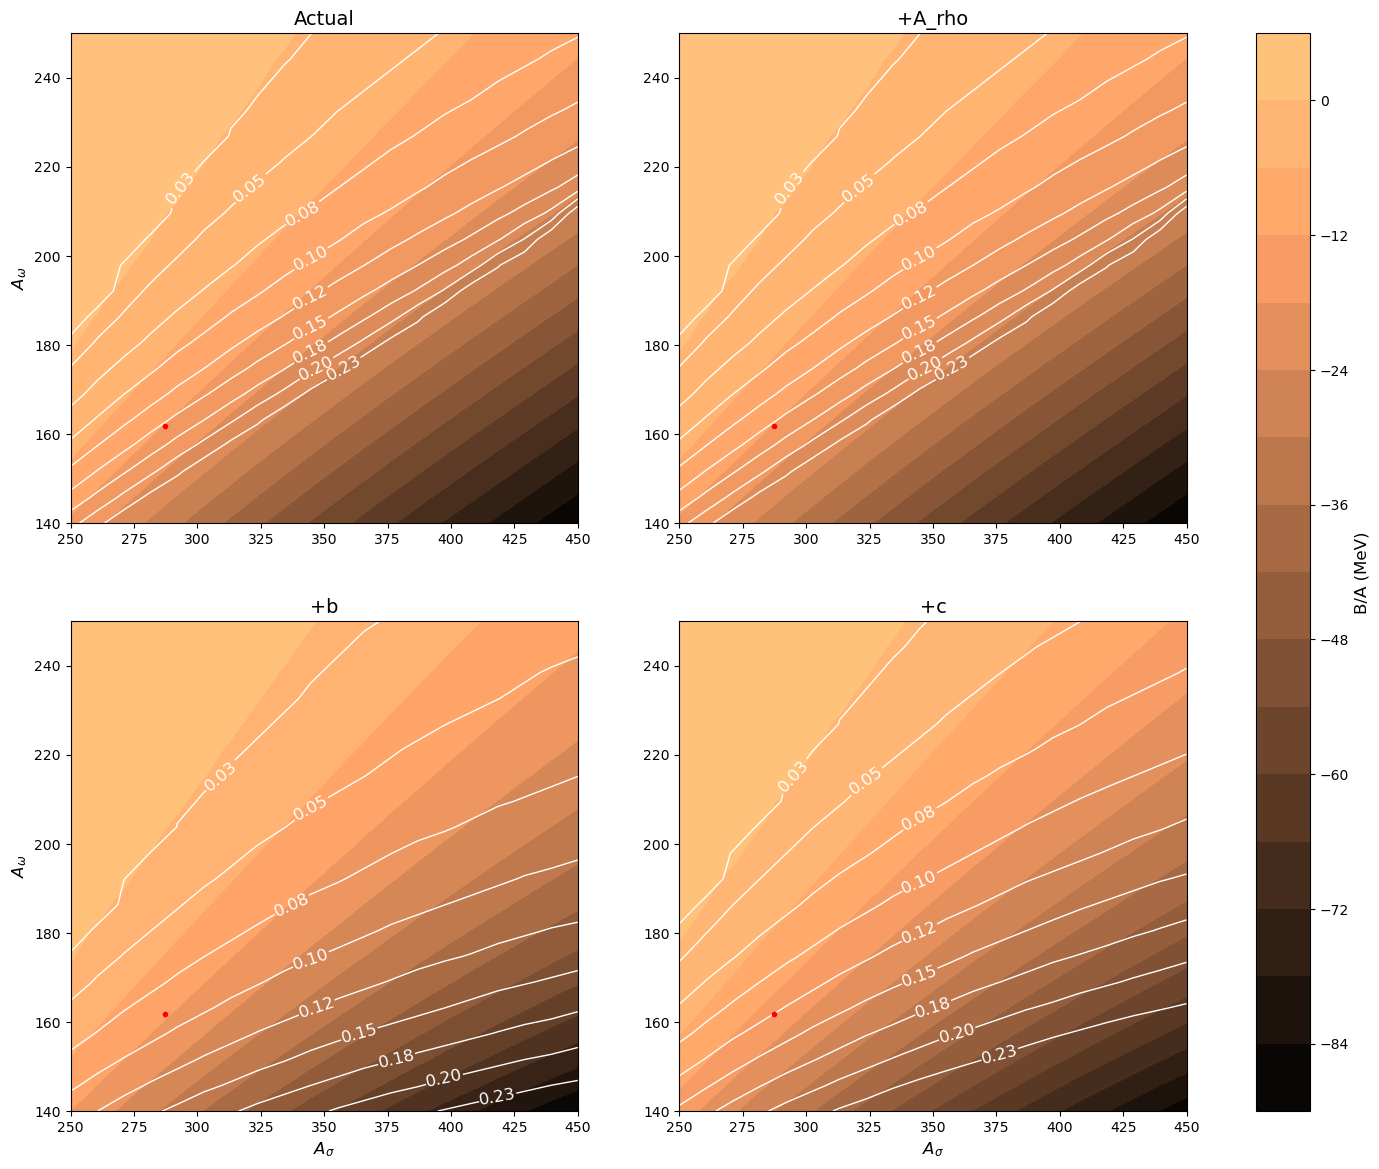

In [ ]:
# Crear malla de A_sigma y A_omega para el mapa de contorno
A_sigma_range = np.linspace(250, 450, 20)
A_omega_range = np.linspace(140, 250, 20)
A_sigma_mesh, A_omega_mesh = np.meshgrid(A_sigma_range, A_omega_range)
n_prove = np.linspace(1e-3, 0.25, 200) # Densidades de bariones en fm^-3

fig, axs = plt.subplots(2, 2, figsize=(18, 14))
# Factores para variar A_rho, b y c en cada subplot: (factor_A_rho, factor_b, factor_c)
factors = [(0, 0, 0), (40, 0, 0), (0, 0.002, 0), (0, 0, 0.002)]
titles = ['Actual', '+A_rho', '+b', '+c']

for idx, (ax, (fr, fb, fc), tit) in enumerate(zip(axs.flat, factors, titles)):
    # determinar fila y columna
    ncols = axs.shape[1]
    row = idx // ncols
    col = idx % ncols

    # inicializar mallas para B/A y n_sat
    ba = np.zeros_like(A_sigma_mesh)
    ns = np.zeros_like(ba)
    for i, j in np.ndindex(ba.shape):
        ns[i, j], ba[i, j], *_ = isoEoS.calculate_properties(
            n_prove,
            [A_sigma_mesh[i, j], A_omega_mesh[i, j], A_rho + fr, b + fb, c + fc, t]
        )
    # contorno relleno y líneas de contorno
    cf = ax.contourf(A_sigma_mesh, A_omega_mesh, ba, 15, cmap='copper')
    cs = ax.contour(A_sigma_mesh, A_omega_mesh, ns, 10, colors='white', linewidths=1)
    ax.clabel(cs, inline=True, fmt='%.2f', fontsize=12, colors='white')
    ax.plot(A_sigma, A_omega, 'ro')
    ax.set_title(tit, fontsize=14)

    # eje x solo en la fila inferior
    if row == axs.shape[0] - 1:
        ax.set_xlabel(r'$A_\sigma$', fontsize=12)
    # eje y solo en la columna izquierda
    if col == 0:
        ax.set_ylabel(r'$A_\omega$', fontsize=12)

# Colorbar compartido para todos los subplots (B/A en MeV)
fig.colorbar(cf, ax=axs.ravel().tolist(), label='B/A (MeV)')
# plt.tight_layout()
plt.show()


In [3]:
# Cálculo de mallas nucleares y estelares
from scripts.EspacioParametros import compute_nuclear_mesh, compute_stellar_mesh, plot_nuclear_mesh, plot_stellar_mesh
# Definir rangos y parámetros
# A_sigma_range = np.linspace(190, 260, 40)
# A_omega_range = np.linspace(101, 130, 40)
A_sigma_range = np.linspace(220, 310, 40)
A_omega_range = np.linspace(134, 185, 40)
params_list = [A_sigma, A_omega, A_rho-20, b-0.0018, c+0.0029]
sat_min, sat_max = 0.15, 0.18
ebind_min, ebind_max = -18, -12
# K_min, K_max = 190, 270

# Cálculo de mallas
n_sat_mesh, ebind_mesh, K_mesh, a_sym_mesh, L_mesh, mask = compute_nuclear_mesh(
    A_sigma_range, A_omega_range, params_list
)

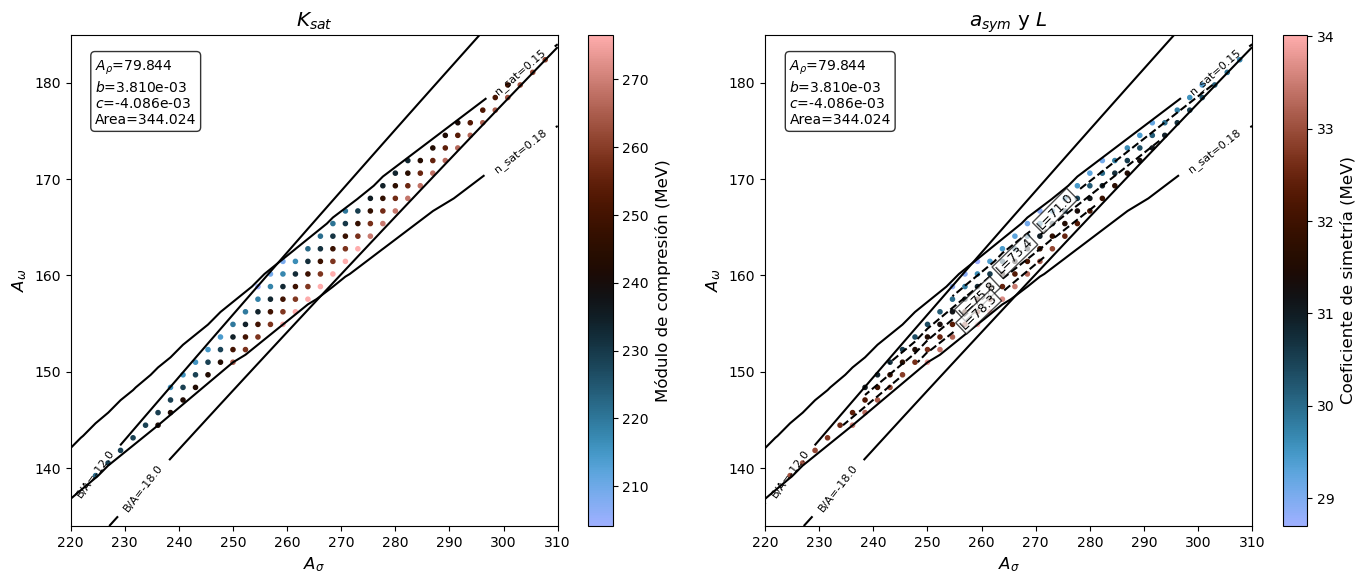

In [4]:
fig_nuclear = plot_nuclear_mesh(
    A_sigma_range, A_omega_range,
    n_sat_mesh, ebind_mesh, K_mesh, a_sym_mesh, L_mesh,
    params_list, equal_aspect=False
)

Aquí utilizamos materia de estrella de neutrones, no la EoS de sigma-omega-rho para nucleones.

In [5]:
mass_mesh, comp_mesh, radius_mesh = compute_stellar_mesh(
    A_sigma_range, A_omega_range, params_list, mask
)

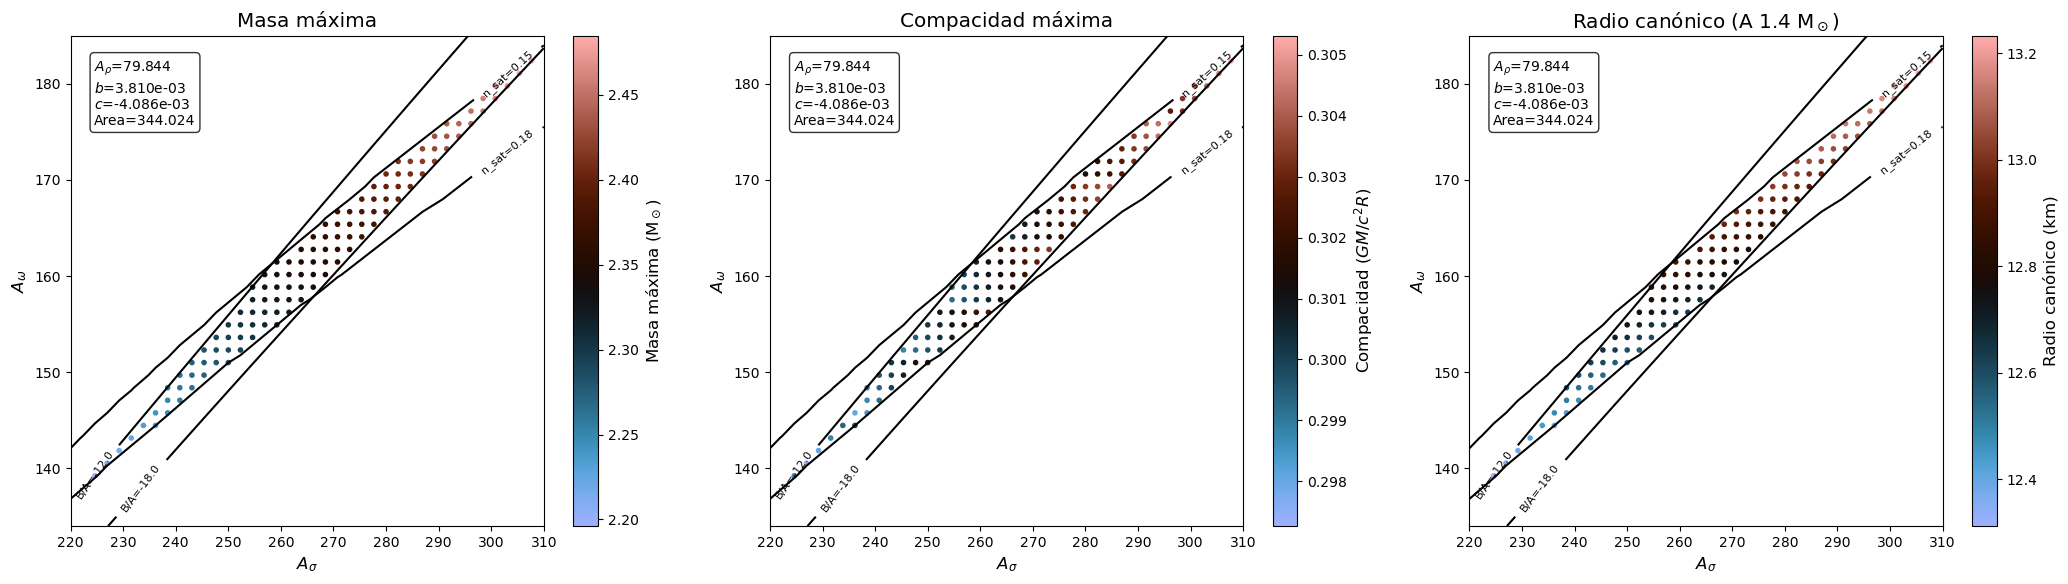

In [6]:
fig_stellar = plot_stellar_mesh(
    A_sigma_range, A_omega_range,
    mass_mesh, comp_mesh, radius_mesh, n_sat_mesh, ebind_mesh,
    params_list
)

In [ ]:
# Guardamos todos los resultados en un archivo .npz
# np.savez('results/EspacioParametros/stellar_mesh_sigma_omega_rho_rho0_lambda_A_propios_3.npz',
#          A_sigma_range=A_sigma_range,
#          A_omega_range=A_omega_range,
#          n_sat_mesh=n_sat_mesh,
#          ebind_mesh=ebind_mesh,
#          K_mesh=K_mesh,
#          a_sym_mesh=a_sym_mesh,
#          L_mesh=L_mesh,
#          mass_mesh=mass_mesh,
#          comp_mesh=comp_mesh,
#          radius_mesh=radius_mesh)

# Leemos mass, comp y radius mesh
# data = np.load('results/EspacioParametros/stellar_mesh_sigma_omega_rho_rho0_lambda_A_propios_3.npz')
# A_sigma_range = data['A_sigma_range']
# A_omega_range = data['A_omega_range']
# n_sat_mesh = data['n_sat_mesh']
# ebind_mesh = data['ebind_mesh']
# K_mesh = data['K_mesh']
# a_sym_mesh = data['a_sym_mesh']
# L_mesh = data['L_mesh']
# mass_mesh = data['mass_mesh']
# comp_mesh = data['comp_mesh']
# radius_mesh = data['radius_mesh']

In [159]:
from pathlib import Path

# Directorio base: subimos un nivel para salir de 'scripts' y quedarnos en la carpeta del proyecto
notebook_dir = Path().resolve()
out_dir = notebook_dir / 'results' / 'EspacioParametros'
out_dir.mkdir(parents=True, exist_ok=True)

def save_with_suffix(fig, base_name, fmt='png', dpi=300):
    """Guarda la figura en out_dir/base_name.ext añadiendo sufijo numérico si ya existe."""
    filename = f"{base_name}.{fmt}"
    path = out_dir / filename
    i = 1
    while path.exists():
        filename = f"{base_name}_{i}.{fmt}"
        path = out_dir / filename
        i += 1
    fig.savefig(str(path), dpi=dpi, bbox_inches='tight')
    rel_path = path.relative_to(notebook_dir)
    print(f"Guardada: {rel_path}")

# Guardar las figuras generadas
save_with_suffix(fig_nuclear, 'espacio_parametros_nuclear')
save_with_suffix(fig_stellar, 'espacio_parametros_estelar')

Guardada: results\EspacioParametros\espacio_parametros_nuclear_3.png
Guardada: results\EspacioParametros\espacio_parametros_estelar_3.png


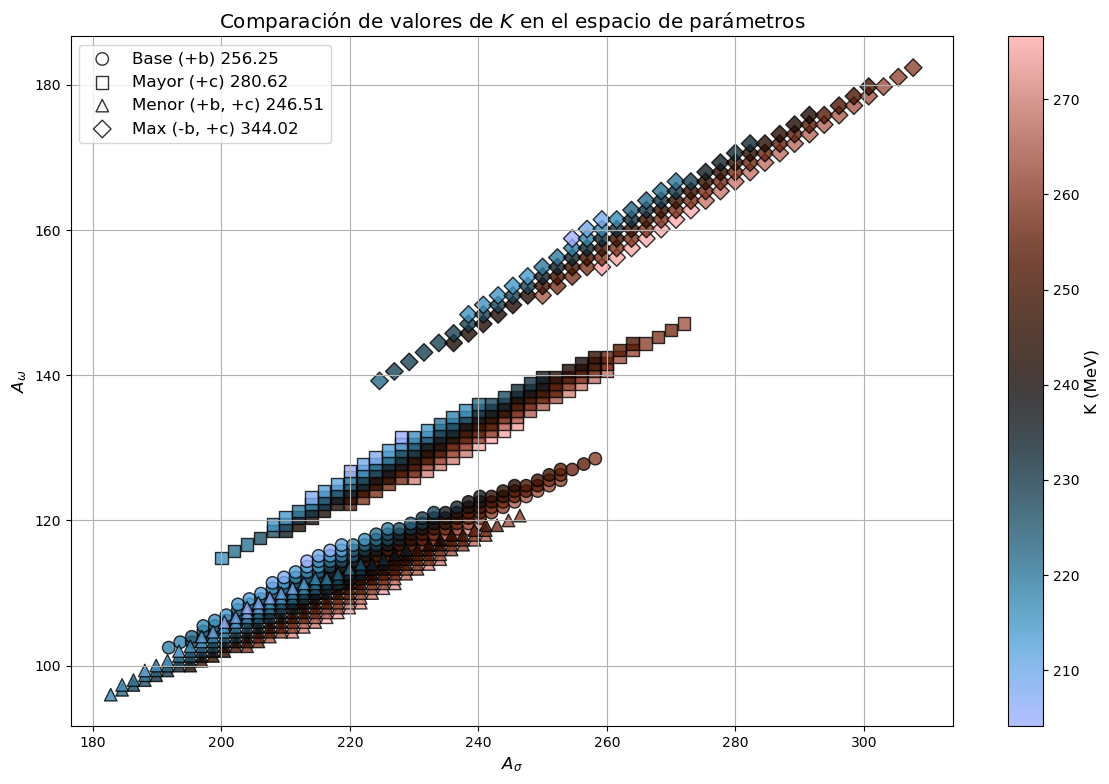

In [8]:
# Realizamos una gráfica comparativa de los 3 conjuntos de datos (stellar_mesh_sigma_omega_rho_rho0_lambda_A_propios(,_1,_2).npz)
# todos en la misma gráfica en el rango del valor mínimo al valor máximo de A_sigma y A_omega (solo gráfica para K)
plt.figure(figsize=(12, 8))
# Hacemos un loop sobre los archivos
basename = 'results/EspacioParametros/stellar_mesh_sigma_omega_rho_rho0_lambda_A_propios'
files = [
    f'{basename}.npz',
    f'{basename}_1.npz',
    f'{basename}_2.npz',
    f'{basename}_3.npz'
]
labels = ['Base (+b)', 'Mayor (+c)', 'Menor (+b, +c)', 'Max (-b, +c)']
markers = ['o', 's', '^', 'D']
for data_file, label, marker in zip(files, labels, markers):
    data = np.load(data_file)
    A_sigma_r = data['A_sigma_range']
    A_omega_r = data['A_omega_range']
    K_mesh = data['K_mesh']
    area_valid = np.sum(np.isfinite(K_mesh)) * (A_sigma_r[1]-A_sigma_r[0]) * (A_omega_r[1]-A_omega_r[0])
    A_s, A_o = np.meshgrid(A_sigma_r, A_omega_r)
    valid = np.isfinite(K_mesh)
    plt.scatter(
        A_s, A_o,
        c=K_mesh, cmap='berlin',
        marker=marker, edgecolor='k', s=80,
        label=label+f' {area_valid:.2f}', alpha=0.8
    )
del data

plt.xlabel(r'$A_\sigma$')
plt.ylabel(r'$A_\omega$')
plt.title('Comparación de valores de $K$ en el espacio de parámetros')
plt.legend()
cbar = plt.colorbar(label='K (MeV)')
plt.tight_layout()
plt.grid()
plt.show()

c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\NSMatterEoS.py:60: RuntimeWarning: invalid value encountered in scalar power
  x_pF = ( (3.0*pi**2)*n_barion/m_nuc**3 - x_nF**3)**(1/3) # Momento de Fermi del protón (y electrón)
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:163: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  dP_dr = -m*rho/r**2*(1+P/rho)*(1+r**3*P/m)/(1-2*m/r)
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:163: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T
c:\User

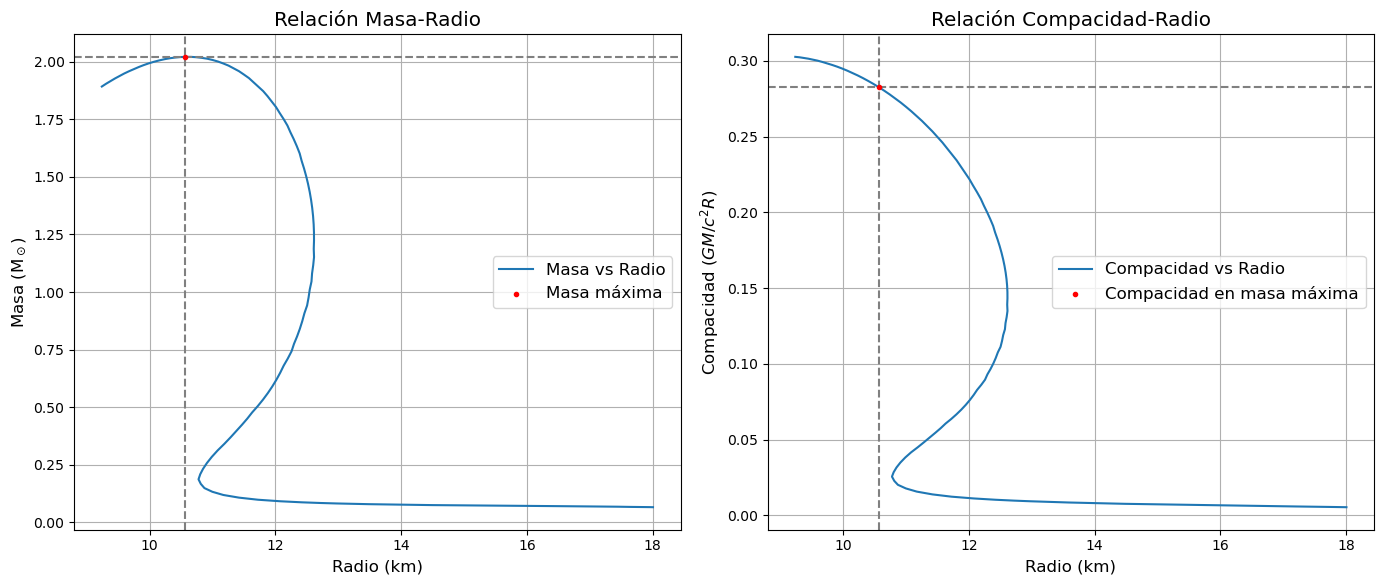

In [ ]:
# Construir EoS y función P(rho)
import scripts.NSMatterEoS as nsEoS
parametros_NS = [200, 115, 88, 0.0081, -0.007]
dens_max = 1e18*1e3*(1e-45/m_nuc_MKS)
dens_min = 1e12*1e3*(1e-45/m_nuc_MKS)
n_range = np.logspace(np.log10(dens_min), np.log10(dens_max), 200)
rho_P, pres, ener, *_ = nsEoS.EoS(n_range, parametros_NS, add_crust=True, crust_file_path='EoS_tables/EoS_crust.txt')
dens_lim = ener[0]
P_rho = CubicSpline(ener, pres)
rhos_central = np.logspace(13.5, 15.5, 150)
masas = np.zeros_like(rhos_central)
radios = np.zeros_like(rhos_central)
compacidades = np.zeros_like(rhos_central)
for i, rho_m in enumerate(rhos_central):
    n_bar = rho_m*1e3/m_nuc_MKS*1e-45
    rho0_dim, _ = nsEoS.energia_presion(n_bar, parametros_NS)
    R = 1.0/rho0_dim
    rho_P_pr = lambda P: R*rho_P(P/R)
    P_central_pr = R*P_rho(1/R)
    dens_lim_pr = R*dens_lim
    rho_nat_to_MKS = 1.0/MeV_to_fm11*MeVfm_to_Jm
    sol = tov.integrador(rf=30.0, dr=1e-3,
                            rho0=rho0_dim*m_nuc**4/2*rho_nat_to_MKS,
                            rho_P=rho_P_pr, P_central=P_central_pr,
                            densidad_limite=dens_lim_pr)
    r_phys, m_phys, *_ = sol
    compacidades[i] = G_MKS*m_phys/c_MKS**2/r_phys
    radios[i] = r_phys*1e-3
    masas[i] = m_phys/1.989e30
argmax = np.argmax(masas)
masa_max = masas[argmax]
radio_max = radios[argmax]
compacidad_max = compacidades[argmax]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Masa–Radio
axes[0].plot(radios, masas, label='Masa vs Radio')
axes[0].scatter(radio_max, masa_max, color='red', zorder=5, label='Masa máxima')
axes[0].axvline(radio_max, color='gray', linestyle='--')
axes[0].axhline(masa_max, color='gray', linestyle='--')
axes[0].set_title('Relación Masa-Radio')
axes[0].set_xlabel('Radio (km)')
axes[0].set_ylabel(r'Masa (M$_\odot$)')
axes[0].legend()
axes[0].grid(True)

# Compacidad–Radio
axes[1].plot(radios, compacidades, label='Compacidad vs Radio')
axes[1].scatter(radio_max, compacidad_max, color='red', zorder=5, label='Compacidad en masa máxima')
axes[1].axvline(radio_max, color='gray', linestyle='--')
axes[1].axhline(compacidad_max, color='gray', linestyle='--')
axes[1].set_title('Relación Compacidad-Radio')
axes[1].set_xlabel('Radio (km)')
axes[1].set_ylabel('Compacidad ($GM/c^2R$)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
